# Data 
https://www.kaggle.com/competitions/rossmann-store-sales/overview

# Import

## Import Library

In [1]:
# ライブラリーの読み込み
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from pmdarima import datasets
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from sklearn.metrics import mean_absolute_error
from statistics import mean 
from matplotlib import pyplot as plt
# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

from statsmodels.tsa.arima.model import ARIMA

## Import Data

In [2]:
!ls data/rossman-store-sales/

sample_submission.csv  store.csv  test.csv  train.csv


In [3]:
# データの読み込み
df_train = pd.read_csv('./data/rossman-store-sales/train.csv', encoding='utf-8')
df_test = pd.read_csv('./data/rossman-store-sales/test.csv')
df_store = pd.read_csv('./data/rossman-store-sales/store.csv')

<ipython-input-3-4d2c62b36edd>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('./data/rossman-store-sales/train.csv', encoding='utf-8')


In [4]:
print('***** Check Columns *****')
print('train:', df_train.columns.to_list())
print('test :', df_test.columns.to_list())

print('***** Check Length *****')
print('train:', len(df_train))
print('test :', len(df_test))

***** Check Columns *****
train: ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
test : ['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
***** Check Length *****
train: 1017209
test : 41088


# データ加工

## 中身確認

In [5]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [9]:
df_store.groupby(['StoreType']).count()

,Store,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
StoreType,,,,,,,,,
a,602,602,601,426,426,602,289,289,289
b,17,17,17,9,9,17,5,5,5
c,148,148,148,107,107,148,75,75,75
d,348,348,346,219,219,348,202,202,202


## 必要な情報だけ抽出

In [10]:
# df_testのIdがいらないので削除
df_test = df_test.drop('Id',axis=1)
df_test.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,4,2015-09-17,1.0,1,0,0
1,3,4,2015-09-17,1.0,1,0,0
2,7,4,2015-09-17,1.0,1,0,0
3,8,4,2015-09-17,1.0,1,0,0
4,9,4,2015-09-17,1.0,1,0,0


In [11]:
print(df_train[df_train['Open']==0])
print(df_train[df_train['Open']==1])

         Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
291        292          5  2015-07-31      0          0     0      1   
875        876          5  2015-07-31      0          0     0      1   
1406       292          4  2015-07-30      0          0     0      1   
1990       876          4  2015-07-30      0          0     0      1   
2521       292          3  2015-07-29      0          0     0      1   
...        ...        ...         ...    ...        ...   ...    ...   
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
291                0              1  
875                0              1  
1406               0 

In [12]:
print(len(df_train[df_train['Open']==0]))
print(len(df_train[df_train['Open']==1]))

df_train = df_train[df_train['Open']==1]

172817
844392


## df_storeをmerge

In [13]:
df_train_all = pd.merge(df_train, df_store, how='inner', on="Store")
df_train_all.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


# ARIMAモデルで予測

## 日次の売上合計金額を分析

In [14]:
df_sum = df_train.groupby(by=['Date'])['Sales'].agg('sum')
print(df_sum)

Date
2013-01-01       97235
2013-01-02     6949829
2013-01-03     6347820
2013-01-04     6638954
2013-01-05     5951593
                ...   
2015-07-27    10707292
2015-07-28     9115073
2015-07-29     8499962
2015-07-30     8798854
2015-07-31    10109742
Name: Sales, Length: 942, dtype: int64


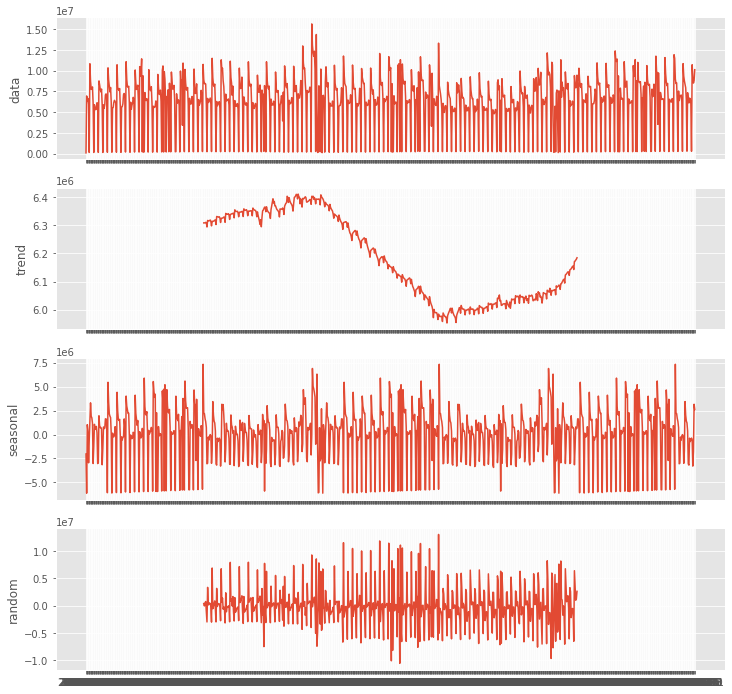

In [15]:
utils.decomposed_plot(arima.decompose(df_sum, 'additive', m=365),
                     figure_kwargs = {'figsize':(12,12)})

In [16]:
# 階差の次数の検討
print('d =', arima.ndiffs(df_sum)) #d（階差）
print('D =', arima.nsdiffs(df_sum,m=365)) #D（季節階差）


d = 0
D = 0


In [17]:
# 通常の階差処理を1回しさらに季節階差処理を1回
data = pd.DataFrame(df_sum)

In [18]:
# データ分割（train:学習データ、test:テストデータ）
train, test = model_selection.train_test_split(df_sum, test_size=31)

In [19]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, 
                             seasonal=True,
                             m=365,
#                              d=1,
#                              D=1,
                             n_jobs=-1,
                             maxiter=10)
# グラフのサイズ変更
plt.rcParams['figure.figsize'] = [12, 9]
# 予測
preds, conf_int = arima_model.predict(n_periods=test.shape[0], 
                                      return_conf_int=True)
# 予測精度
print('MAE:')
print(mean_absolute_error(test, preds)) 
print('MAPE(%):')
print(mean(abs(test - preds)/test) *100)
# 予測と実測の比較（グラフ）
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis,test,label="actual",color='r') 
plt.plot(x_axis,preds,label="predicted",color='b')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()
# グラフ（学習データとテストデータ、予測結果）
x_axis = np.arange(train.shape[0] + preds.shape[0])
plt.plot(x_axis[:train.shape[0]],train,color='r',label="actual")
plt.plot(x_axis[train.shape[0]:],test,color='r')
plt.plot(x_axis[train.shape[0]:],preds,color='b',label="predicted")
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1,color='b')
plt.legend()
plt.show()

/home/hajime/.local/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


KeyboardInterrupt: 

-> うまくできていない

##  売上が一番大きい店舗について、注目して分析

In [37]:
df_sum_store = df_train.groupby(by=['Store'])['Sales'].agg('sum')
# 一番売上が大きい店舗を確認
print(df_sum_store.sort_values())
# -> 262

Store
307      2114322
543      2179287
198      2268273
208      2302052
263      2306075
          ...   
251     14896870
1114    16202585
562     16927322
817     17057867
262     19516842
Name: Sales, Length: 1115, dtype: int64


In [22]:
df_train_262 = df_train[df_train['Store']==262]
print(df_train_262)

         Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
261        262          5  2015-07-31  25774       3669     1      1   
1376       262          4  2015-07-30  22253       3132     1      1   
2491       262          3  2015-07-29  21041       3123     1      1   
3606       262          2  2015-07-28  22442       3143     1      1   
4721       262          1  2015-07-27  22185       3150     1      1   
...        ...        ...         ...    ...        ...   ...    ...   
1011896    262          6  2013-01-05  14868       2735     1      0   
1013011    262          5  2013-01-04  16849       3009     1      0   
1014126    262          4  2013-01-03  16616       2943     1      0   
1015241    262          3  2013-01-02  16964       3113     1      0   
1016356    262          2  2013-01-01  17267       2875     1      0   

        StateHoliday  SchoolHoliday  
261                0              1  
1376               0              1  
2491               0 

In [23]:
df_train_262_sale = pd.Series(list(df_train_262['Sales']), index=df_train_262['Date'])
print(df_train_262_sale)

Date
2015-07-31    25774
2015-07-30    22253
2015-07-29    21041
2015-07-28    22442
2015-07-27    22185
              ...  
2013-01-05    14868
2013-01-04    16849
2013-01-03    16616
2013-01-02    16964
2013-01-01    17267
Length: 942, dtype: int64


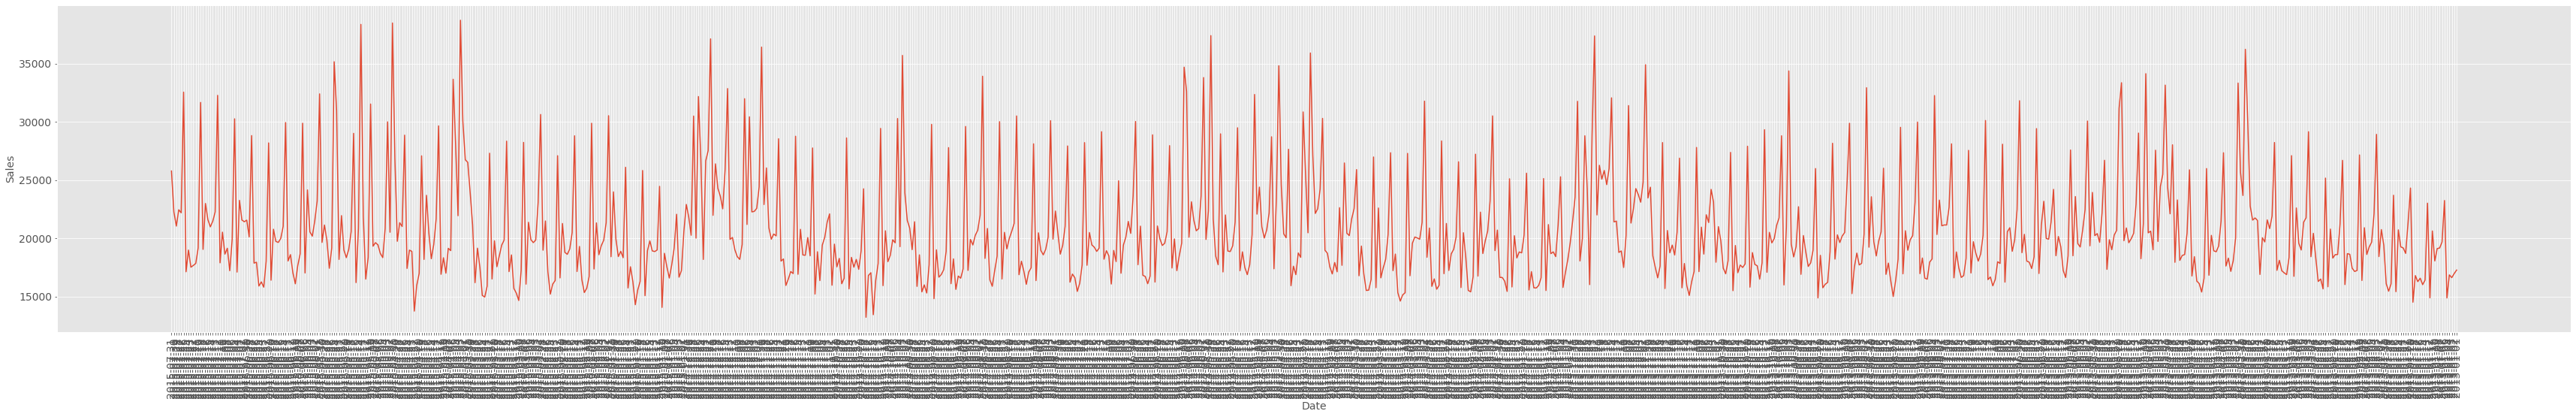

In [24]:
plt.figure(figsize=(60, 8))
plt.plot(df_train_262_sale)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

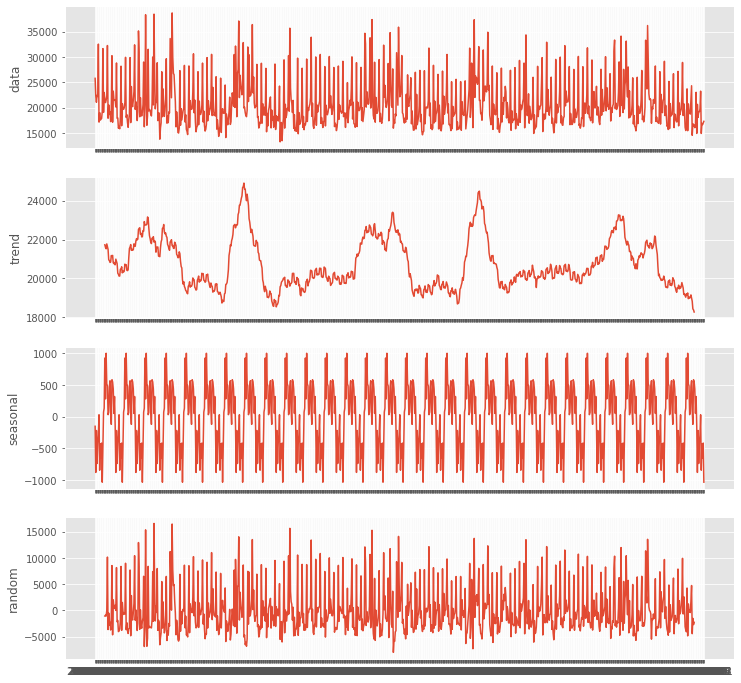

In [25]:
utils.decomposed_plot(arima.decompose(df_train_262_sale, 'additive', m=31),
                     figure_kwargs = {'figsize':(12,12)})

In [26]:
# 階差の次数の検討
print('d =', arima.ndiffs(df_train_262_sale)) #d（階差）
print('D =', arima.nsdiffs(df_train_262_sale,m=365)) #D（季節階差）

d = 0
D = 0


In [28]:
# # ADF検定（原系列）
# dftest = adfuller(df_train_262_sale)
# print('ADF Statistic: %f' % dftest[0])
# print('p-value: %f' % dftest[1])
# print('Critical values :')
# for k, v in dftest[4].items():
#     print('\t', k, v)

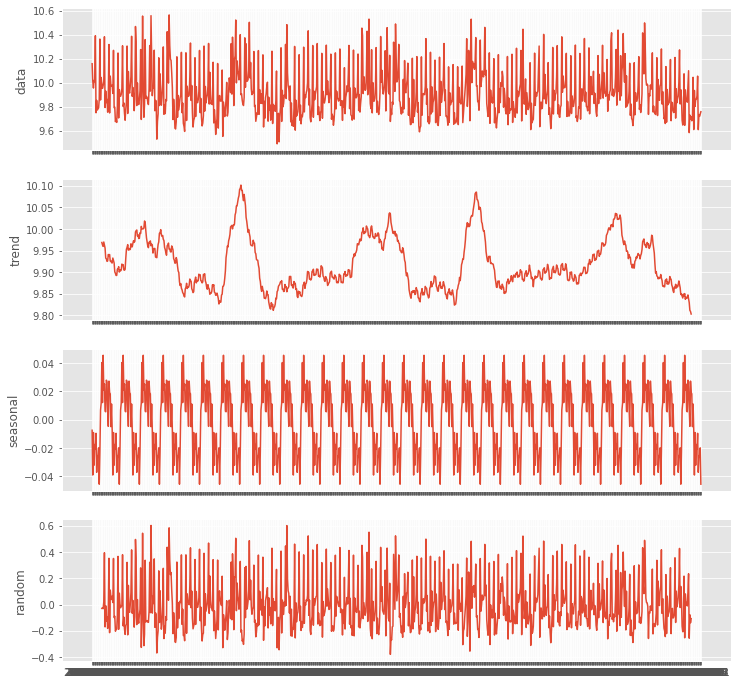

In [29]:
utils.decomposed_plot(arima.decompose(np.log(df_train_262_sale), 'additive', m=31),
                     figure_kwargs = {'figsize':(12,12)})

In [30]:
# # ADF検定（原系列）
# dftest = adfuller(np.log(df_train_262_sale))
# print('ADF Statistic: %f' % dftest[0])
# print('p-value: %f' % dftest[1])
# print('Critical values :')
# for k, v in dftest[4].items():
#     print('\t', k, v)

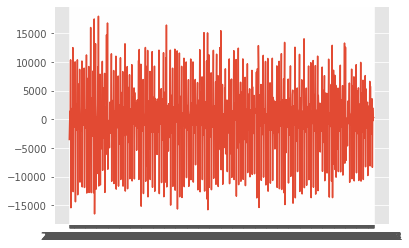

In [31]:
# 階差
df_log_diff1 = df_train_262_sale.diff(1).dropna()
plt.plot(df_log_diff1)

In [33]:
# # ADF検定
# dftest = adfuller(df_log_diff1)
# print('ADF Statistic: %f' % dftest[0])
# print('p-value: %f' % dftest[1])
# print('Critical values :')
# for k, v in dftest[4].items():
#     print('\t', k, v)

In [34]:
# from statsmodels.tsa.stattools import adfuller


# def my_adf(d):
#     ps = [0.01,0.05]
#     for reg in ['nc','c','ct','ctt']:
#         adf,pvalue,usedlag,nobs,critical_values,icbest = adfuller(
#             x = d,
#             regression = reg,
#             autolag = 'AIC'
#         )
#     ps.append(pvalue)

#     return ps

# fig,axs = plt.subplots(4,1)
# #a1=1のケースの階差をとる
# # data4 = pd.Series(data2).diff().dropna()
# for ax,d in zip(axs,df_train_262_sale_train):
#     ax.bar(height=my_adf(d),x='0.01,0.05,nc,c,ct,ctt'.split(','))

/home/hajime/.local/lib/python3.8/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (365) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/home/hajime/.local/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


MAE:
3050.777114628698
MAPE(%):
18.104869797832805


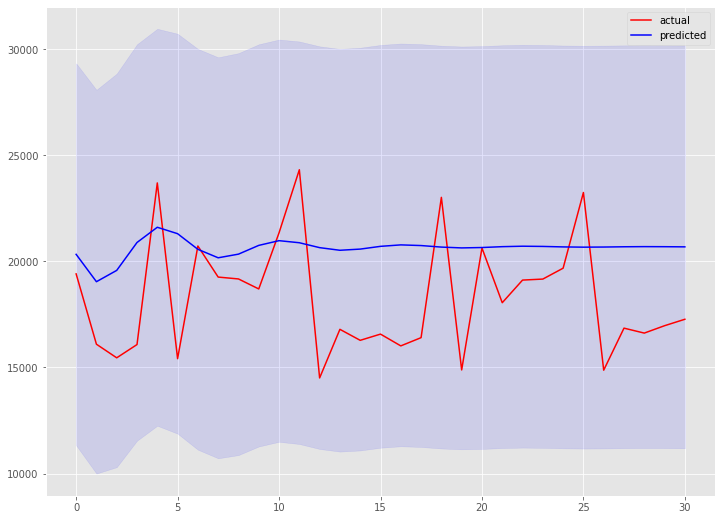

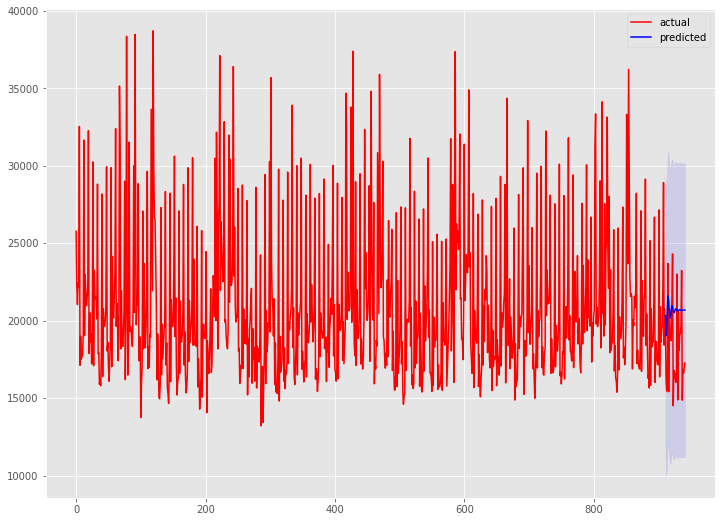

In [35]:
# データ分割（train:学習データ、test:テストデータ）
train, test = model_selection.train_test_split(df_train_262_sale, test_size=31)

# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, 
                             seasonal=False,
                             m=365,
#                              d=1,
#                              D=1,
                             n_jobs=-1,
                             maxiter=10)
# グラフのサイズ変更
plt.rcParams['figure.figsize'] = [12, 9]
# 予測
preds, conf_int = arima_model.predict(n_periods=test.shape[0], 
                                      return_conf_int=True)
# 予測精度
print('MAE:')
print(mean_absolute_error(test, preds)) 
print('MAPE(%):')
print(mean(abs(test - preds)/test) *100)
# 予測と実測の比較（グラフ）
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis,test,label="actual",color='r') 
plt.plot(x_axis,preds,label="predicted",color='b')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()
# グラフ（学習データとテストデータ、予測結果）
x_axis = np.arange(train.shape[0] + preds.shape[0])
plt.plot(x_axis[:train.shape[0]],train,color='r',label="actual")
plt.plot(x_axis[train.shape[0]:],test,color='r')
plt.plot(x_axis[train.shape[0]:],preds,color='b',label="predicted")
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1,color='b')
plt.legend()
plt.show()

# VARモデルで予測

In [36]:
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.api import VAR
import seaborn as sns
import matplotlib.pyplot as plt

result_dir_path = Path('result')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

##  売上が一番大きい店舗について、注目して分析

In [40]:
df_sum_store = df_train.groupby(by=['Store'])['Sales'].agg('sum')
# 一番売上が大きい店舗を確認
print(df_sum_store.sort_values())
# -> 262

Store
307      2114322
543      2179287
198      2268273
208      2302052
263      2306075
          ...   
251     14896870
1114    16202585
562     16927322
817     17057867
262     19516842
Name: Sales, Length: 1115, dtype: int64


In [60]:
df_train_262 = df_train[df_train['Store']==262].drop(['Store','Open'],axis=1)\
    .sort_values('Date').reset_index(drop=True)
print(df_train_262)

     DayOfWeek        Date  Sales  Customers  Promo StateHoliday  \
0            2  2013-01-01  17267       2875      0            a   
1            3  2013-01-02  16964       3113      0            0   
2            4  2013-01-03  16616       2943      0            0   
3            5  2013-01-04  16849       3009      0            0   
4            6  2013-01-05  14868       2735      0            0   
..         ...         ...    ...        ...    ...          ...   
937          1  2015-07-27  22185       3150      1            0   
938          2  2015-07-28  22442       3143      1            0   
939          3  2015-07-29  21041       3123      1            0   
940          4  2015-07-30  22253       3132      1            0   
941          5  2015-07-31  25774       3669      1            0   

     SchoolHoliday  
0                1  
1                1  
2                1  
3                1  
4                0  
..             ...  
937              1  
938            

In [57]:
adf = stattools.adfuller(df_train_262['Sales'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -5.77, p値 : 0.0%
データ数 : 920, 使用されたラグ数 : 21
検定統計量における棄却値 : 1%=-4.38, 5%=-3.84, 10%=-3.56


In [82]:
df_train_262_sort = df_train_262[['Sales','Customers']]
print(df_train_262_sort)

# データ分割（train:学習データ、test:テストデータ）
train, test = model_selection.train_test_split(df_train_262_sort, test_size=31)

x = sm.add_constant(train)
model = VAR(train)

     Sales  Customers
0    17267       2875
1    16964       3113
2    16616       2943
3    16849       3009
4    14868       2735
..     ...        ...
937  22185       3150
938  22442       3143
939  21041       3123
940  22253       3132
941  25774       3669

[942 rows x 2 columns]


In [83]:
model.select_order(15).summary()

,AIC,BIC,FPE,HQIC
0,27.60,27.61,9.685e+11,27.60
1,27.06,27.09,5.659e+11,27.07
2,27.02,27.08,5.447e+11,27.04
3,26.88,26.95,4.702e+11,26.90
4,26.87,26.97,4.693e+11,26.91
5,26.71,26.82,3.964e+11,26.75
6,26.59,26.73,3.537e+11,26.64
7,26.20,26.36,2.380e+11,26.26
8,26.10,26.28,2.158e+11,26.17
9,26.09,26.30,2.147e+11,26.17


In [84]:
model_result = model.fit(maxlags=15, ic='aic')
model_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 01, Sep, 2022
Time:                     02:53:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    26.1680
Nobs:                     896.000    HQIC:                   25.9628
Log likelihood:          -14055.3    FPE:                1.66132e+11
AIC:                      25.8360    Det(Omega_mle):     1.55206e+11
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const              7465.322642      1535.613466            4.861           0.000
L1.Sales              0.176905         0.094218            1.878           0.060
L1.Customers          1.497896         0.798177            1

0 Sales
1 Customers


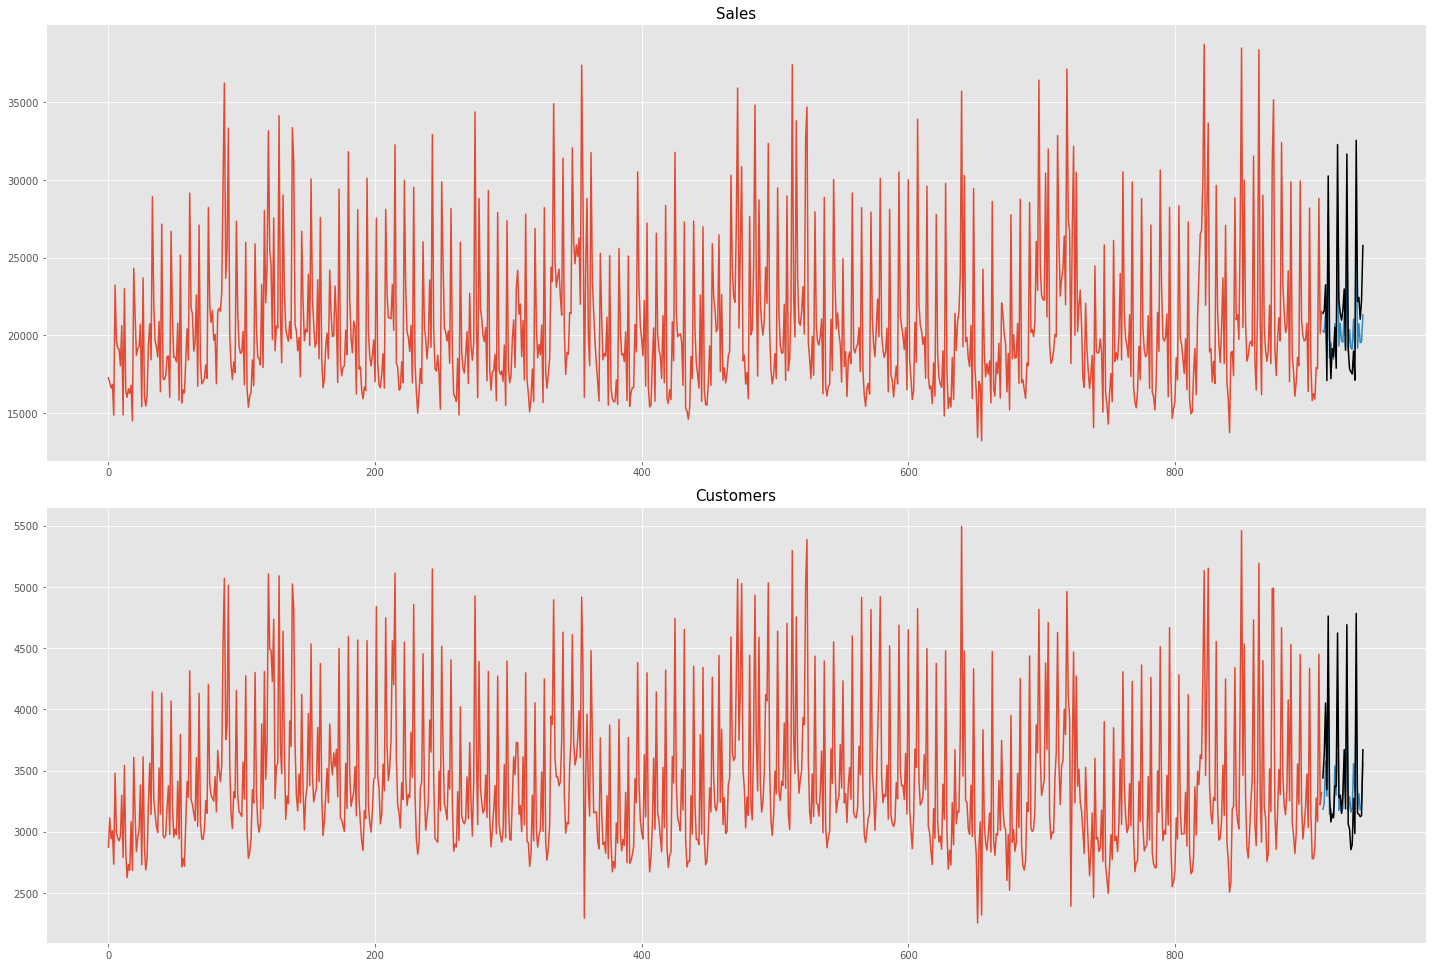

In [117]:
steps = 31
result = model_result.forecast(model_result.endog, steps=steps)

fig = plt.figure(0, figsize=(20, 20))
for i, variable_name in enumerate(['Sales', 'Customers']):
    
    print(i, variable_name)
    ax = fig.add_subplot(3, 1, i+1)
    y = model_result.endog[:, i]
    plt_test = np.array(test[variable_name])
    ax.plot(
        np.arange(len(y)),
        y,
        'r'
    )
    ax.plot(
        np.arange(len(y), len(y)+steps),
        result[:, i],
        ''
    )
    ax.plot(
        np.arange(len(y), len(y)+steps),
        plt_test,
        color='k'
    )
    ax.set_title(variable_name, size=15)
    
fig.tight_layout()
plt.savefig(result_dir_path.joinpath('micro_data_predict.png'))

0 Sales
1 Customers


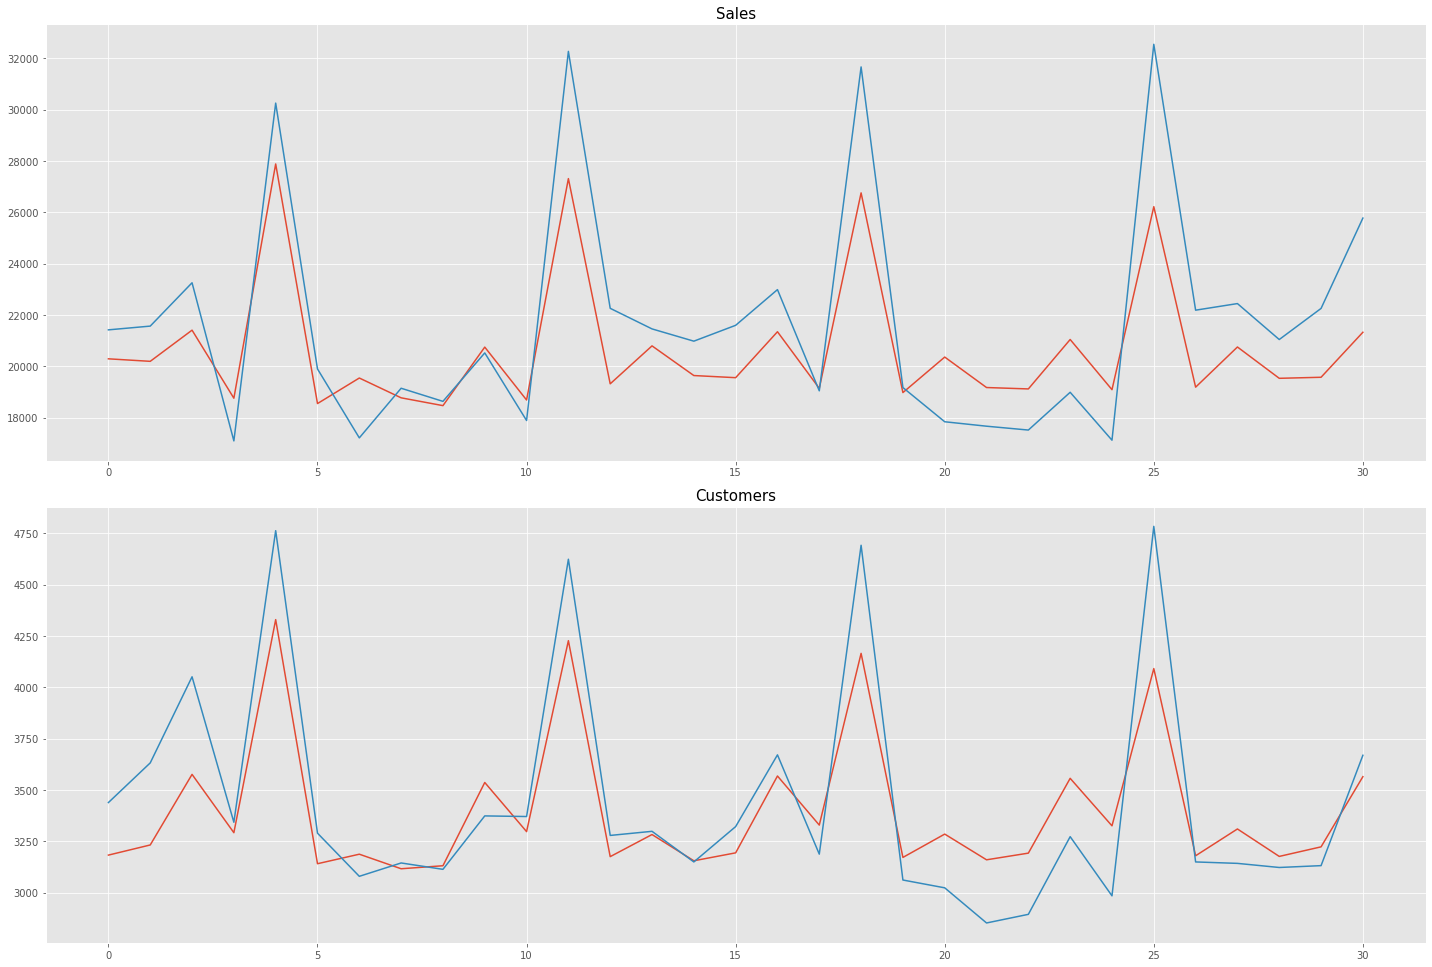

In [119]:
fig = plt.figure(0, figsize=(20, 20))
for i, variable_name in enumerate(['Sales', 'Customers']):
    
    print(i, variable_name)
    ax = fig.add_subplot(3, 1, i+1)
    plt_test = np.array(test[variable_name])
    ax.plot(
        np.arange(steps),
        result[:, i]
    )
    ax.plot(
        np.arange(steps),
        plt_test,
    )
    ax.set_title(variable_name, size=15)
    
fig.tight_layout()
plt.savefig(result_dir_path.joinpath('micro_data_predict.png'))

In [81]:
len(result)

20

In [110]:
y

array([17267, 16964, 16616, 16849, 14868, 23240, 19674, 19161, 19113,
       18047, 20625, 14880, 23011, 16401, 16013, 16568, 16275, 16793,
       14503, 24312, 21341, 18696, 19167, 19255, 20718, 15410, 23691,
       16076, 15451, 16092, 19405, 20744, 18423, 28921, 22116, 19661,
       19249, 18607, 20904, 16372, 27154, 17233, 17145, 17422, 18620,
       18678, 16018, 26690, 21216, 18601, 18590, 18296, 20788, 15830,
       25164, 15650, 16495, 16288, 18299, 20419, 18411, 29150, 21749,
       21379, 18989, 19565, 22601, 16727, 27094, 18352, 16876, 17024,
       17209, 18101, 17238, 28221, 21903, 20830, 21578, 19685, 20043,
       16888, 21527, 21742, 21557, 22753, 29903, 36227, 23672, 25672,
       33326, 20036, 18063, 17155, 18290, 17609, 27342, 21475, 19328,
       18839, 18917, 20245, 16820, 25986, 16561, 15380, 16105, 16319,
       18418, 16757, 25876, 20443, 18598, 18518, 18095, 23289, 17931,
       28026, 22098, 24377, 33151, 25478, 24444, 19723, 27559, 19007,
       20605, 20465,

In [103]:
type(y)

numpy.ndarray

In [107]:
plt_test = np.array(test['Sales'])
type(plt_test)

numpy.ndarray

In [114]:
test

,Sales,Customers
911,21418,3439
912,21564,3632
913,23253,4051
914,17090,3343
915,30255,4762
916,19894,3290
917,17208,3080
918,19142,3145
919,18631,3114
920,20519,3374
